## ML Model Selection
- 1. LR (Logistic Regression) : Baseline Model
- 2. XGB (XGBoost)
- 3. LGBM (LightGBM)

## Load Library & Data

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pandas_gbq

import requests
from bs4 import BeautifulSoup
import json
import lxml

from datetime import datetime, timedelta
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import MarkerCluster

from shapely.geometry import Point, Polygon, MultiPolygon, shape
from shapely import wkt

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report,  roc_curve, auc, RocCurveDisplay
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance

import googlemaps
from google.cloud import bigquery
from google.oauth2 import service_account

import os
import glob
import warnings
import sys

import xgboost as xgb
import lightgbm as lgb
import sklearn

print('sklearn version: %s' % sklearn.__version__)
print('xgboost version: %s' % xgb.__version__)
print('lightgbm version: %s' % lgb.__version__)

DATA_PATH = "data/"
KEY_PATH = "config/"

key_path = KEY_PATH + "fireforest-team-ys-2023.json"
servicekey_path = KEY_PATH + "serviceKey.json"

warnings.filterwarnings("ignore")
%matplotlib inline

sklearn version: 1.2.1
xgboost version: 1.7.5
lightgbm version: 3.3.5


In [2]:
def get_service_key(servicekey_path, key_name):
    """
    주어진 서비스 키 파일에서 지정된 키 이름에 해당하는 서비스 키를 반환합니다.

    Args:
        servicekey_path (str): 서비스 키 파일의 경로.
        key_name (str): 반환할 서비스 키의 이름.

    Returns:
        str or None: 지정된 키 이름에 해당하는 서비스 키. 키를 찾을 수 없는 경우 None을 반환합니다.
    """
    
    with open(servicekey_path) as f:
        data = json.load(f)
        service_key = data.get(key_name)
    return service_key

In [3]:
def get_dataframe_from_bigquery(dataset_id, table_id, key_path):
    """
    주어진 BigQuery 테이블에서 데이터를 조회하여 DataFrame으로 반환합니다.

    Args:
        dataset_id (str): 대상 데이터셋의 ID.
        table_id (str): 대상 테이블의 ID.
        key_path (str): 서비스 계정 키 파일의 경로.

    Returns:
        pandas.DataFrame: 조회된 데이터를 담은 DataFrame 객체.
    """

    # Credentials 객체 생성
    credentials = service_account.Credentials.from_service_account_file(key_path)

    # BigQuery 클라이언트 생성
    client = bigquery.Client(credentials=credentials, project=credentials.project_id)

    # 테이블 레퍼런스 생성
    table_ref = client.dataset(dataset_id).table(table_id)

    # 테이블 데이터를 DataFrame으로 변환
    df = client.list_rows(table_ref).to_dataframe()

    return df

In [4]:
def split_train_test(data):
    """
    입력된 데이터를 학습 및 테스트 데이터로 분할하고 클래스 불균형을 해결하기 위해 SMOTE를 적용합니다.

    Args:
        data (DataFrame): 피처와 레이블을 포함하는 입력 데이터.

    Returns:
        tuple: 4개의 요소를 포함하는 튜플:
            - X_train_over (DataFrame): SMOTE를 적용한 학습용 피처 데이터.
            - X_test (DataFrame): 테스트용 피처 데이터.
            - y_train_over (Series): SMOTE를 적용한 학습용 레이블 데이터.
            - y_test (Series): 테스트용 레이블 데이터.
    """

    # 기간을 고려하여 train, test 데이터 나누기
    train_start = '2013-01-01'
    train_end = '2020-12-31'
    test_start = '2021-01-01'
    test_end = '2022-12-31'

    train_mask = (data['tm'] >= train_start) & (data['tm'] <= train_end)
    test_mask = (data['tm'] >= test_start) & (data['tm'] <= test_end)

    train_data = data[train_mask]
    test_data = data[test_mask]

    X_train = train_data.drop(['w_regions', 'tm', 'fire_occur'], axis=1)
    y_train = train_data['fire_occur']

    X_train = X_train.astype(float)
    y_train = y_train.astype(int)

    # SMOTE 적용
    smote = SMOTE(random_state=42)
    
    X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

    print('======================================================')
    print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", X_train.shape, y_train.shape)
    print('======================================================')
    print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
    print('======================================================')
    print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts())

    X_test = test_data.drop(['w_regions', 'tm', 'fire_occur'], axis=1)
    y_test = test_data['fire_occur']
    
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)

    print('======================================================')
    print("테스트용 피처/레이블 데이터 세트 : ", X_test.shape, y_test.shape)
    print('======================================================')
    print('테스트 데이터 값의 분포 :\n',pd.Series(y_test).value_counts() )
    print('======================================================')

    return X_train_over, X_test, y_train_over, y_test

In [5]:
def display_results (y_real, pred, pred_proba):
    """
    분류 결과를 출력합니다.

    Args:
        y_real (array-like): 실제 레이블 값.
        pred (array-like): 예측값.
        pred_proba (array-like): 예측 확률 값.

    Returns:
        None
    """

    print("confusion matrix is:")
    print(confusion_matrix(y_real, pred))
    print('======================================================') 
    print("Accuracy score is:", accuracy_score(y_real, pred))  
    print('======================================================') 
    print("Precision is : ", precision_score(y_real, pred))
    print('======================================================') 
    print("Recall is : ", recall_score(y_real, pred))
    print('======================================================') 
    print("F1 score is : ", f1_score(y_real, pred))
    print('======================================================') 
    print("ROC AUC score is : ", roc_auc_score(y_real, pred_proba))
    print('======================================================')     
    print("Classification report is:")
    print(classification_report(y_real, pred))

In [6]:
def calculate_tpr_fpr(y_real, y_pred):
    """
    실제 값과 예측 값으로부터 True Positive Rate(TPR)와 False Positive Rate(FPR)를 계산합니다.

    Args:
        y_real (array-like): 실제 레이블 값.
        y_pred (array-like): 예측값.

    Returns:
        tpr (float): True Positive Rate(TPR).
        fpr (float): False Positive Rate(FPR).
    """
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [7]:
def get_n_roc_coordinates(y_real, y_proba, n = 50):
    """
    실제 값과 예측 확률 값으로부터 주어진 개수(n)에 따른 TPR과 FPR 좌표를 얻습니다.

    Args:
        y_real (array-like): 실제 레이블 값.
        y_proba (array-like): 예측 확률 값.
        n (int, optional): TPR과 FPR 좌표 개수. 기본값은 50입니다.

    Returns:
        tpr_list (list): TPR 좌표 리스트.
        fpr_list (list): FPR 좌표 리스트.
    """

    tpr_list = [0]
    fpr_list = [0]

    for i in range(n):
        threshold = i/n
        y_pred = y_proba[:, 1] > threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        
    return tpr_list, fpr_list

In [8]:
def plot_roc_curve(tpr, fpr, scatter = True):
    """
    TPR과 FPR 좌표를 사용하여 ROC 곡선을 그립니다.

    Args:
        tpr (array-like): TPR 좌표 값.
        fpr (array-like): FPR 좌표 값.
        scatter (bool, optional): 점 표시 여부. 기본값은 True입니다.

    Returns:
        None
    """

    plt.figure(figsize = (5, 5))
    sns.lineplot(x = fpr, y = tpr)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', linestyle="dashed")
    plt.xlabel("False Positive Rate (Positive label: 1)")
    plt.ylabel("True Positive Rate (Positive label: 1)")
    plt.show()

In [9]:
def plot_dwi_intervals(y_real, pred, pred_proba, num_intervals=10):
    """
    DWI 등급 구간에 따라 Forestfire_occur와 Non_Forestfire_occur 값을 계산하고, 그래프를 그립니다.

    Args:
        y_real (Series): 테스트 레이블 데이터.
        pred (array-like): 예측값.
        pred_proba (array-like): 예측 확률 값.
        num_intervals (int, optional): DWI 등급의 개수. 기본값은 10입니다.

    Returns:
        None
    """
    
    # DWI 등급 구간 설정
    interval_labels = [f"{int((i+1)*10)}%" for i in range(num_intervals)]

    # DWI 등급
    dwis = list(range(1, num_intervals+1))

    # Forestfire_occur와 Non_Forestfire_occur 값
    forestfire_occur = np.zeros(num_intervals)
    non_forestfire_occur = np.zeros(num_intervals)

    # 예측값의 숫자에 따라 count
    for pred in pred_proba:
        idx = int((1 - pred) * 10)
        if idx == 10:
            idx -= 1
        for i in range(idx, num_intervals):
            forestfire_occur[i] += 1

    # Non_Forestfire_occur 값
    total_samples = len(pred_proba)
    non_forestfire_occur = total_samples - forestfire_occur

    # 구간 범위 추정
    interval_ranges = []
    for i in range(num_intervals):
        if i == 0:
            lower_percentile = np.percentile(pred_proba, i * 10)
            upper_percentile = np.percentile(pred_proba, (i + 1) * 10)
            interval_range = f"[{0.0000:.4f}∼{upper_percentile:.4f}]"

        elif i == num_intervals-1:
            lower_percentile = np.percentile(pred_proba, i * 10)
            upper_percentile = np.percentile(pred_proba, (i + 1) * 10)
            interval_range = f"[{lower_percentile:.4f}∼{1.0000:.4f}]"

        else:
            lower_percentile = np.percentile(pred_proba, i * 10)
            upper_percentile = np.percentile(pred_proba, (i + 1) * 10)
            interval_range = f"[{lower_percentile:.4f}∼{upper_percentile:.4f}]"
        interval_ranges.append(interval_range)

    # 데이터 프레임 생성
    data = {
        'Interval ratio': interval_labels,
        'DWI': dwis,
        'Interval range': interval_ranges,
        'Forestfire_occur': forestfire_occur,
        'Non_Forestfire_occur': non_forestfire_occur
    }

    df = pd.DataFrame(data)

    display(df)


    # 그래프 그리기
    plt.plot(df['DWI'], df['Forestfire_occur'], marker='o', label='Forestfire_occur', color="red")
    plt.plot(df['DWI'], df['Non_Forestfire_occur'], marker='o', label='Non_Forestfire_occur', color="blue")

    # 수치 표시
    for x, y1, y2 in zip(df['DWI'], df['Forestfire_occur'], df['Non_Forestfire_occur']):
        plt.text(x, y1+10, str(int(y1)), ha='center', va='bottom')
        plt.text(x, y2+10, str(int(y2)), ha='center', va='bottom')

    # 축 및 레이블 설정
    plt.xlabel('DWI')
    plt.ylabel('Count')
    plt.xticks(df['DWI'])
    plt.title('Forestfire_occur and Non_Forestfire_occur by DWI')

    # 범례 표시
    plt.legend(loc='upper right', ncol=2)

    max_value = max(df['Forestfire_occur'].max(), df['Non_Forestfire_occur'].max())
    plt.ylim(bottom=-50, top=max_value + 150) 
    
    plt.show()

In [10]:
data_1 = get_dataframe_from_bigquery("ANALSIS_DATA", "GangwonNorthInland", key_path).sort_values(["tm"]).reset_index(drop=True)
data_2 = get_dataframe_from_bigquery("ANALSIS_DATA", "GangwonNorthMount", key_path).sort_values(["tm"]).reset_index(drop=True)
data_3 = get_dataframe_from_bigquery("ANALSIS_DATA", "GangwonNorthCoast", key_path).sort_values(["tm"]).reset_index(drop=True)
data_4 = get_dataframe_from_bigquery("ANALSIS_DATA", "GangwonCentralInland", key_path).sort_values(["tm"]).reset_index(drop=True)
data_5 = get_dataframe_from_bigquery("ANALSIS_DATA", "GangwonCentralMount", key_path).sort_values(["tm"]).reset_index(drop=True)
data_6 = get_dataframe_from_bigquery("ANALSIS_DATA", "GangwonCentralCoast", key_path).sort_values(["tm"]).reset_index(drop=True)
data_7 = get_dataframe_from_bigquery("ANALSIS_DATA", "GangwonSouthInland", key_path).sort_values(["tm"]).reset_index(drop=True)
data_8 = get_dataframe_from_bigquery("ANALSIS_DATA", "GangwonSouthMount", key_path).sort_values(["tm"]).reset_index(drop=True)
data_9 = get_dataframe_from_bigquery("ANALSIS_DATA", "GangwonSouthInland", key_path).sort_values(["tm"]).reset_index(drop=True)

data_1 = data_1[data_1['tm'] < '2023-01-01']
data_2 = data_2[data_2['tm'] < '2023-01-01']
data_3 = data_3[data_3['tm'] < '2023-01-01']
data_4 = data_4[data_4['tm'] < '2023-01-01']
data_5 = data_5[data_5['tm'] < '2023-01-01']
data_6 = data_6[data_6['tm'] < '2023-01-01']
data_7 = data_7[data_7['tm'] < '2023-01-01']
data_8 = data_8[data_8['tm'] < '2023-01-01']
data_9 = data_9[data_9['tm'] < '2023-01-01']

## Split data into separate training and test set 

In [11]:
X_train, X_test, y_train, y_test = split_train_test(data_1)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (2922, 14) (2922,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (5736, 14) (5736,)
SMOTE 적용 후 값의 분포 :
 0    2868
1    2868
Name: fire_occur, dtype: int64
테스트용 피처/레이블 데이터 세트 :  (730, 14) (730,)
테스트 데이터 값의 분포 :
 0    722
1      8
Name: fire_occur, dtype: int64
(5736, 14) (730, 14)
(5736,) (730,)


In [12]:
#### Model Parameter

# LR
lr_model = LogisticRegression(solver='liblinear', random_state=0)

# XGB
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }

xgb_model = XGBClassifier(booster='gbtree', importance_type='gain', **params)

# LGBM
params = {
            'class_weight':'balanced',
            'drop_rate': 0.9,
            'min_data_in_leaf': 100,
            'max_bin': 255,
            'n_estimators': 500,
            'min_sum_hessian_in_leaf': 1,
            'learning_rate': 0.1,
            'bagging_fraction':  0.85,
            'colsample_bytree': 1.0,
            'feature_fraction': 0.1,
            'lambda_l1': 5.0,
            'lambda_l2': 3.0,
            'max_depth': 9,
            'min_child_samples': 55,
            'min_child_weight': 5.0,
            'min_split_gain': 0.1,
            'num_leaves': 45,
            'subsample': 0.75
        }

lgb_model = LGBMClassifier(boosting_type='dart', importance_type='gain', **params)

## Model Evaluation 1 - LR

In [13]:
lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [14]:
pred = lr_model.predict(X_train)
pred_proba = lr_model.predict_proba(X_train)[:, 1]

In [15]:
display_results(y_train, pred, pred_proba)

confusion matrix is:
[[2393  475]
 [ 332 2536]]
Accuracy score is: 0.8593096234309623
Precision is :  0.8422451012952508
Recall is :  0.8842398884239888
F1 score is :  0.8627317571015478
ROC AUC score is :  0.9357754688390532
Classification report is:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86      2868
           1       0.84      0.88      0.86      2868

    accuracy                           0.86      5736
   macro avg       0.86      0.86      0.86      5736
weighted avg       0.86      0.86      0.86      5736



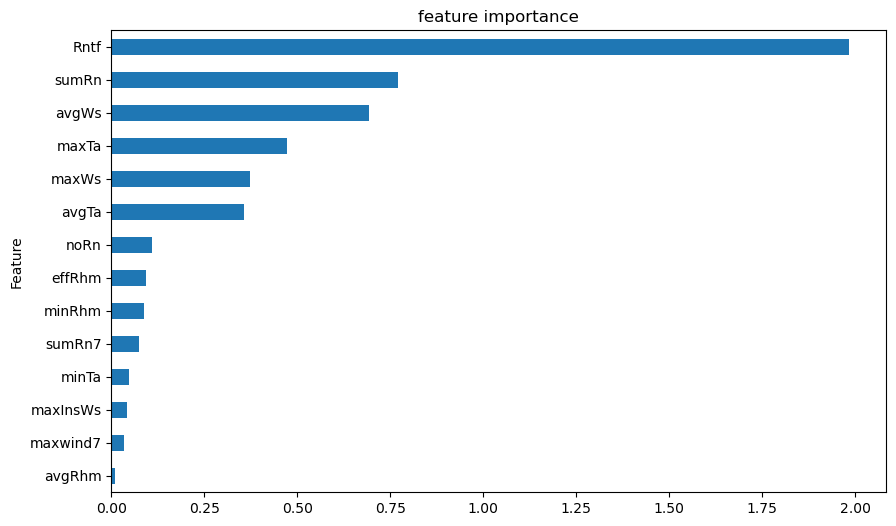

In [16]:
coefficients = lr_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot.barh(x='Feature', y='Importance', figsize=(10, 6), legend=False, title='feature importance')
plt.show();

In [17]:
pred = lr_model.predict(X_test)
pred_proba = lr_model.predict_proba(X_test)[:, 1]

In [18]:
display_results(y_test, pred, pred_proba)

confusion matrix is:
[[664  58]
 [  4   4]]
Accuracy score is: 0.915068493150685
Precision is :  0.06451612903225806
Recall is :  0.5
F1 score is :  0.1142857142857143
ROC AUC score is :  0.89196675900277
Classification report is:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       722
           1       0.06      0.50      0.11         8

    accuracy                           0.92       730
   macro avg       0.53      0.71      0.53       730
weighted avg       0.98      0.92      0.95       730



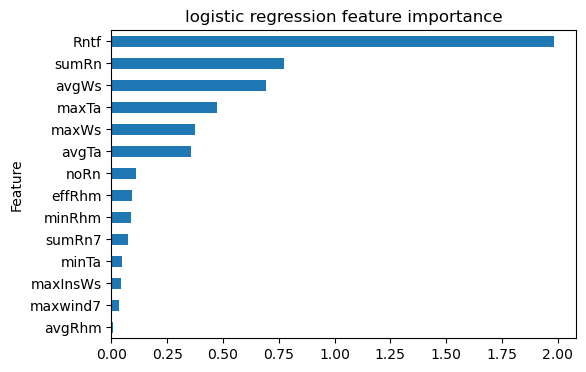

In [19]:
coefficients = lr_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot.barh(x='Feature', y='Importance', figsize=(6, 4), legend=False, title='logistic regression feature importance')
plt.show();

,Interval ratio,DWI,Interval range,Forestfire_occur,Non_Forestfire_occur
0,10%,1,[0.0000∼0.0000],7.0,723.0
1,20%,2,[0.0000∼0.0001],20.0,710.0
2,30%,3,[0.0001∼0.0010],29.0,701.0
3,40%,4,[0.0010∼0.0059],47.0,683.0
4,50%,5,[0.0059∼0.0166],62.0,668.0
5,60%,6,[0.0166∼0.0345],77.0,653.0
6,70%,7,[0.0345∼0.0918],111.0,619.0
7,80%,8,[0.0918∼0.1965],143.0,587.0
8,90%,9,[0.1965∼0.4355],211.0,519.0
9,100%,10,[0.4355∼1.0000],730.0,0.0


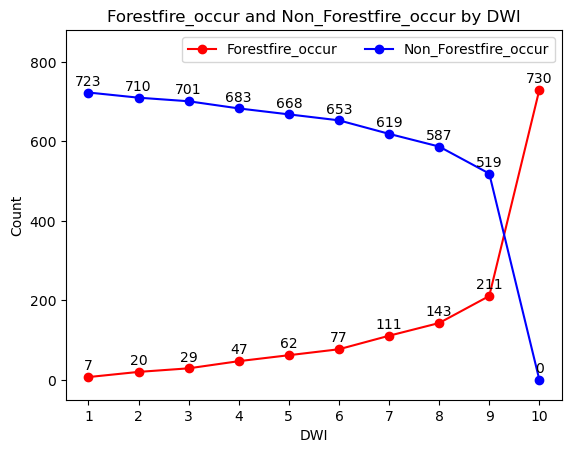

In [20]:
plot_dwi_intervals(y_test, pred, pred_proba)

## Model Evaluation 2 - XGBoost

In [21]:
# XGB
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }

xgb_model = XGBClassifier(booster='gbtree', importance_type='gain', **params)
xgb_model.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type='gain',
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [22]:
xgb_model.feature_importances_

array([0.08761901, 0.01312977, 0.05107978, 0.03303421, 0.02886168,
       0.00903657, 0.0209052 , 0.27430055, 0.06689642, 0.07484099,
       0.06483933, 0.19560376, 0.02520118, 0.05465156], dtype=float32)

In [23]:
pred = xgb_model.predict(X_train)
pred_proba = xgb_model.predict_proba(X_train)[:, 1]

In [24]:
display_results(y_train, pred, pred_proba)

confusion matrix is:
[[2815   53]
 [  10 2858]]
Accuracy score is: 0.9890167364016736
Precision is :  0.9817931982136723
Recall is :  0.9965132496513249
F1 score is :  0.9890984599411662
ROC AUC score is :  0.9995878631910039
Classification report is:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2868
           1       0.98      1.00      0.99      2868

    accuracy                           0.99      5736
   macro avg       0.99      0.99      0.99      5736
weighted avg       0.99      0.99      0.99      5736



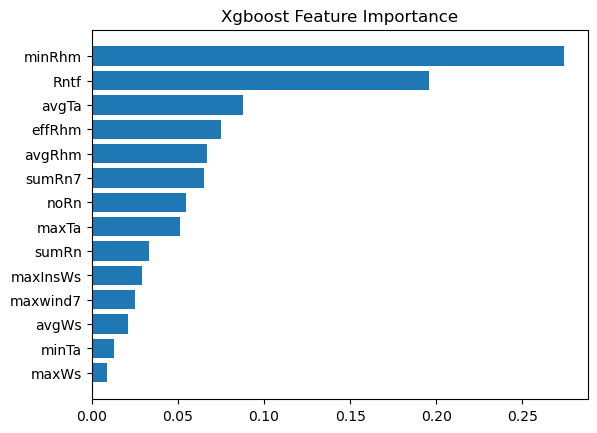

In [25]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.title("Xgboost Feature Importance")
plt.show()

In [26]:
pred = xgb_model.predict(X_test)
pred_proba = xgb_model.predict_proba(X_test)[:, 1]

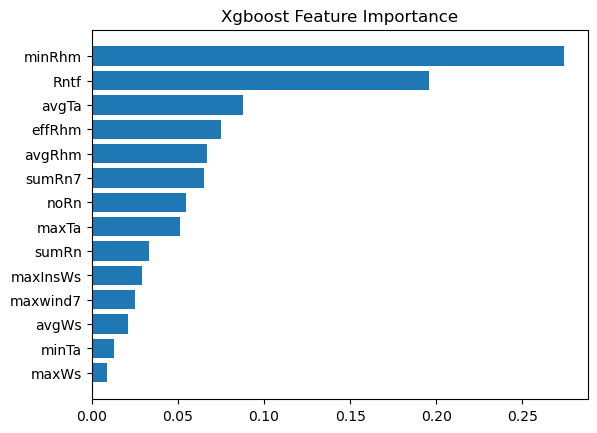

In [27]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.title("Xgboost Feature Importance")
plt.show()

,Interval ratio,DWI,Interval range,Forestfire_occur,Non_Forestfire_occur
0,10%,1,[0.0000∼0.0003],3.0,727.0
1,20%,2,[0.0003∼0.0005],4.0,726.0
2,30%,3,[0.0005∼0.0007],6.0,724.0
3,40%,4,[0.0007∼0.0010],7.0,723.0
4,50%,5,[0.0010∼0.0015],16.0,714.0
5,60%,6,[0.0015∼0.0024],21.0,709.0
6,70%,7,[0.0024∼0.0033],27.0,703.0
7,80%,8,[0.0033∼0.0067],35.0,695.0
8,90%,9,[0.0067∼0.0367],47.0,683.0
9,100%,10,[0.0367∼1.0000],730.0,0.0


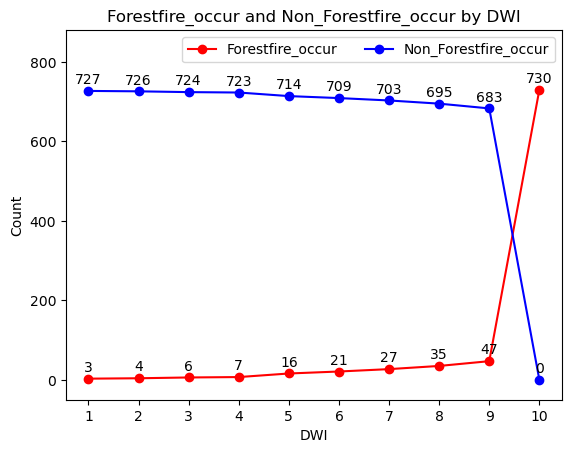

In [28]:
plot_dwi_intervals(y_test, pred, pred_proba)

## Model Evaluation 3 - LightGBM

In [29]:
# LGBM
params = {
            'class_weight':'balanced',
            'drop_rate': 0.9,
            'min_data_in_leaf': 100,
            'max_bin': 255,
            'n_estimators': 500,
            'min_sum_hessian_in_leaf': 1,
            'learning_rate': 0.1,
            'bagging_fraction':  0.85,
            'colsample_bytree': 1.0,
            'feature_fraction': 0.1,
            'lambda_l1': 5.0,
            'lambda_l2': 3.0,
            'max_depth': 9,
            'min_child_samples': 55,
            'min_child_weight': 5.0,
            'min_split_gain': 0.1,
            'num_leaves': 45,
            'subsample': 0.75
        }

lgb_model = LGBMClassifier(boosting_type='dart', importance_type='gain', **params)
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=5.0 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.75 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0


LGBMClassifier(bagging_fraction=0.85, boosting_type='dart',
               class_weight='balanced', drop_rate=0.9, feature_fraction=0.1,
               importance_type='gain', lambda_l1=5.0, lambda_l2=3.0,
               max_bin=255, max_depth=9, min_child_samples=55,
               min_child_weight=5.0, min_data_in_leaf=100, min_split_gain=0.1,
               min_sum_hessian_in_leaf=1, n_estimators=500, num_leaves=45,
               subsample=0.75)

In [30]:
lgb_model.feature_importances_

array([ 7536.85230556,  7215.38069098,  5488.98507468,  2282.01589189,
        4374.72729024,  9386.01452383, 16257.54416749, 25860.43470589,
       15651.34635404, 10257.56198254, 10469.70592273,  4626.08879995,
        9793.14502235,   950.02262639])

In [31]:
pred = lgb_model.predict(X_train)
pred_proba = lgb_model.predict_proba(X_train)[:, 1]

In [32]:
display_results(y_train, pred, pred_proba)

confusion matrix is:
[[2742  126]
 [  24 2844]]
Accuracy score is: 0.9738493723849372
Precision is :  0.9575757575757575
Recall is :  0.9916317991631799
F1 score is :  0.974306269270298
ROC AUC score is :  0.9977720297458221
Classification report is:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2868
           1       0.96      0.99      0.97      2868

    accuracy                           0.97      5736
   macro avg       0.97      0.97      0.97      5736
weighted avg       0.97      0.97      0.97      5736



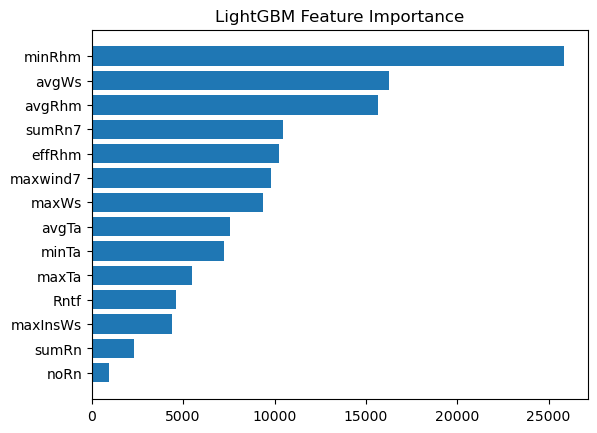

In [33]:
sorted_idx = lgb_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], lgb_model.feature_importances_[sorted_idx])
plt.title("LightGBM Feature Importance")
plt.show()

In [34]:
pred = lgb_model.predict(X_test)
pred_proba = lgb_model.predict_proba(X_test)[:, 1]

In [35]:
display_results(y_test, pred, pred_proba)

confusion matrix is:
[[707  15]
 [  4   4]]
Accuracy score is: 0.9739726027397261
Precision is :  0.21052631578947367
Recall is :  0.5
F1 score is :  0.2962962962962963
ROC AUC score is :  0.9059903047091413
Classification report is:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       722
           1       0.21      0.50      0.30         8

    accuracy                           0.97       730
   macro avg       0.60      0.74      0.64       730
weighted avg       0.99      0.97      0.98       730



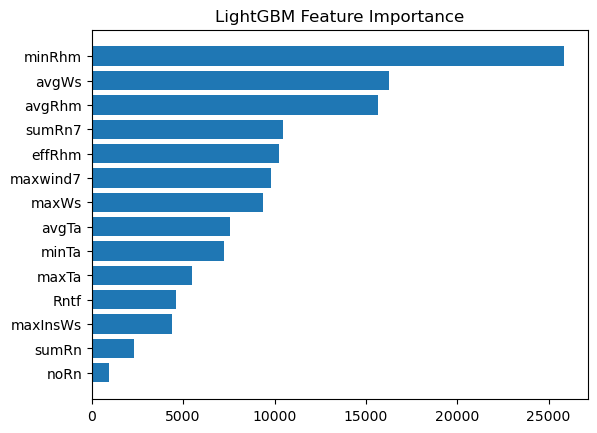

In [36]:
sorted_idx = lgb_model.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_idx], lgb_model.feature_importances_[sorted_idx])
plt.title("LightGBM Feature Importance")
plt.show()

,Interval ratio,DWI,Interval range,Forestfire_occur,Non_Forestfire_occur
0,10%,1,[0.0000∼0.0012],0.0,730.0
1,20%,2,[0.0012∼0.0020],1.0,729.0
2,30%,3,[0.0020∼0.0034],4.0,726.0
3,40%,4,[0.0034∼0.0066],11.0,719.0
4,50%,5,[0.0066∼0.0108],19.0,711.0
5,60%,6,[0.0108∼0.0186],33.0,697.0
6,70%,7,[0.0186∼0.0364],55.0,675.0
7,80%,8,[0.0364∼0.0826],77.0,653.0
8,90%,9,[0.0826∼0.2128],124.0,606.0
9,100%,10,[0.2128∼1.0000],730.0,0.0


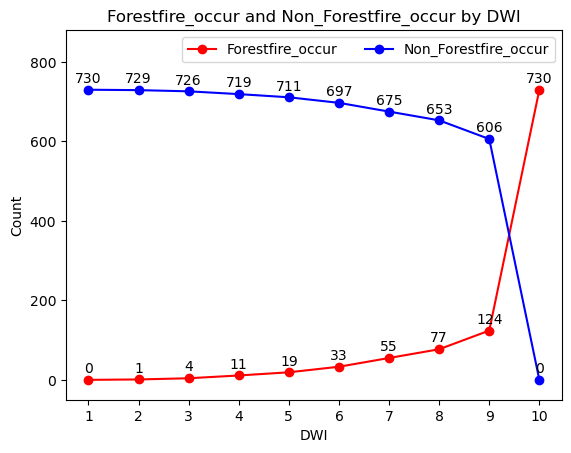

In [37]:
plot_dwi_intervals(y_test, pred, pred_proba)

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=5.0 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.75 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0


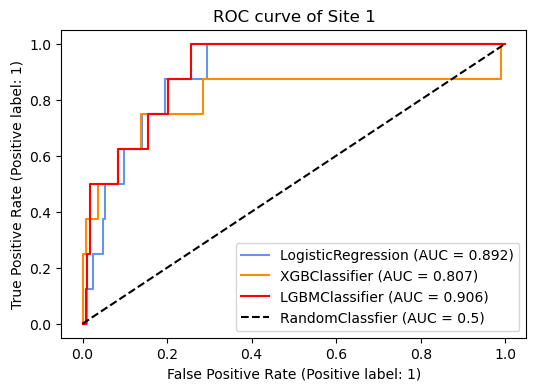

In [38]:
# LR
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)

#XGB
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)

#LGBM
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)


# Plots the ROC curve using the sklearn methods (sklearn + matplolib.pyplot)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr[:,1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb[:,1])
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_proba_lgb[:,1])

roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

plt.figure(figsize=(6,4))
plt.grid(False)

plt.plot(fpr_lr, tpr_lr, label=f'LogisticRegression (AUC = {roc_auc_lr:.3f})', color='cornflowerblue')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBClassifier (AUC = {roc_auc_xgb:.3f})', color='darkorange')
plt.plot(fpr_lgb, tpr_lgb, label=f'LGBMClassifier (AUC = {roc_auc_lgb:.3f})', color='red')
plt.plot([0, 1], [0, 1], label=f'RandomClassfier (AUC = 0.5)', color = 'black', linestyle="dashed")
plt.xlabel("False Positive Rate (Positive label: 1)")
plt.ylabel("True Positive Rate (Positive label: 1)")
plt.title("ROC curve of Site 1")
plt.legend()
plt.show()